## Task 2 :

Task 2 is about analyze data scientist salaries across different data science jobs from 2020 to 2024 in order to extract valuable insights and understand trends in the industry. Through this analysis, we aim to identify the most prevalent job titles, explore the distribution of salaries, and standardize them to a single currency for meaningful comparisons. By leveraging Exploratory Data Analysis (EDA) techniques and visualization tools, we seek to gain insights into factors influencing salary variations, job title, experience level and much more.

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
import numpy as np

### Pre-Analysis:

In [103]:
df = pd.read_csv("task2.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13972 entries, 0 to 13971
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Work_Year         13972 non-null  int64 
 1   Experience_Level  13972 non-null  object
 2   Employment_Type   13972 non-null  object
 3   Job_Title         13972 non-null  object
 4   Salary            13972 non-null  int64 
 5   Salary_Currency   13972 non-null  object
 6   Remote_Ratio      13972 non-null  int64 
 7   Company_Size      13972 non-null  object
dtypes: int64(3), object(5)
memory usage: 873.4+ KB


,Work_Year,Salary,Remote_Ratio
count,13972.000000,1.397200e+04,13972.000000
mean,2023.085600,1.660011e+05,33.334526
std,0.687612,3.661545e+05,46.682931
min,2020.000000,1.400000e+04,0.000000
25%,2023.000000,1.040000e+05,0.000000
50%,2023.000000,1.422000e+05,0.000000
75%,2024.000000,1.880000e+05,100.000000
max,2024.000000,3.040000e+07,100.000000


In [104]:
for column in df.columns:
    missing_values = df[column].isnull().sum()
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Number of missing values: {missing_values}")
    print(f"{len(unique_values)} Unique values: {unique_values}")
    print()

Column: Work_Year
Number of missing values: 0
5 Unique values: [2024 2023 2022 2020 2021]

Column: Experience_Level
Number of missing values: 0
4 Unique values: ['Senior-Level' 'Mid-Level' 'Entry-Level' 'Executive-Level']

Column: Employment_Type
Number of missing values: 0
4 Unique values: ['Full-Time' 'Contract' 'Part-Time' 'Freelance']

Column: Job_Title
Number of missing values: 0
146 Unique values: ['AI Engineer' 'Machine Learning Engineer'
 'Business Intelligence Developer' 'Data Engineer' 'Data Scientist'
 'Cloud Database Engineer' 'Research Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Applied Scientist' 'Data Science Manager'
 'Research Scientist' 'Prompt Engineer' 'Data Science'
 'Data Science Consultant' 'Data Management Analyst' 'Research Analyst'
 'Data Operations Analyst' 'Data Management Consultant'
 'Business Intelligence Analyst' 'Analytics Engineer'
 'Data Quality Analyst' 'Data Architect' 'Data Manager' 'ML Engineer'
 'Robotics Software Engineer' 'Machine L

To determine if there are any missing values, we can print the `.info()` method of the dataframe. Additionally, for better comprehension of the dataset, it's helpful to print the unique values. Upon inspection, we identified a misspelled word "S" instead of "Small", but aside from that, there were no missing data.

In [105]:
df['Company_Size'] = df['Company_Size'].replace('S', 'Small')

In [106]:
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    num_duplicate_rows = len(duplicate_rows)
    total_rows = len(df)
    print("Number of duplicate rows:", num_duplicate_rows)
    print("Percentage of duplicate rows: {:.2%}".format(num_duplicate_rows / total_rows))
else:
    print("No duplicates found!")

Number of duplicate rows: 5565
Percentage of duplicate rows: 39.83%


Based on the observation that approximately 39.83% of the rows in the dataset are duplicates, it can be assumed that these duplicated rows represent different individuals who share similar characteristics in terms of income. It suggests that their income is likely determined by factors such as their job title and tier within the organization rather than any additional credits for extra hours or supplementary income sources. Therefore, it can be inferred that a significant portion of the dataset reflects a pattern where individuals with identical roles and positions receive similar incomes.

In [107]:
currency_counts = df['Salary_Currency'].value_counts()
print("Currency Counts befroe removing:")
print(currency_counts,"\n")

currencies_to_remove = currency_counts[currency_counts < 10].index
df = df[~df['Salary_Currency'].isin(currencies_to_remove)]

currency_counts = df['Salary_Currency'].value_counts()
print("Currency Counts after removing:")
print(currency_counts)

Currency Counts befroe removing:
Salary_Currency
USD    12876
GBP      522
EUR      414
INR       52
CAD       49
AUD       12
PLN        7
CHF        6
SGD        6
JPY        4
BRL        4
DKK        3
HUF        3
TRY        3
NOK        2
THB        2
ZAR        1
HKD        1
ILS        1
PHP        1
NZD        1
MXN        1
CLP        1
Name: count, dtype: int64 

Currency Counts after removing:
Salary_Currency
USD    12876
GBP      522
EUR      414
INR       52
CAD       49
AUD       12
Name: count, dtype: int64


We also removed currencies that occurred fewer than 10 times in our data frame. This ensures that our data analysis focuses only on currencies with a more substantial presence in our dataset, thereby improving the reliability of our findings.

In [108]:
df.to_csv("task2_cleaned.csv", index=False)

#### Converting Currencies to USD:

In [109]:
from forex_python.converter import CurrencyRates

df = pd.read_csv("task2_cleaned.csv")

currencies = df['Salary_Currency'].unique()
print(currencies)

['USD' 'EUR' 'GBP' 'CAD' 'AUD' 'INR']


In [110]:
exchange_rates = {}

cr = CurrencyRates()
for currency in currencies:
    if currency != 'USD':
        exchange_rates[currency] = cr.get_rate(currency, 'USD')

In [111]:
print("Exchange rates for each currency to USD:\n",exchange_rates)

Exchange rates for each currency to USD:
 {'EUR': 1.0768, 'GBP': 1.2578704514923194, 'CAD': 0.7416999586719933, 'AUD': 0.6519343706484229, 'INR': 0.012047235725513668}


In [112]:
def convert_to_usd(amount, currency):
    if currency != 'USD':
        return round(amount * exchange_rates[currency])
    else:
        return amount

df['Salary'] = df.apply(lambda row: int(convert_to_usd(row['Salary'], row['Salary_Currency'])), axis=1)

df['Salary_Currency'] = 'USD'

In [113]:
df.to_csv("task2_USD.csv", index=False)

### Exploratory Data Analysis (EDA):

Basic Statistics for Salary:
count     13925.000000
mean     150326.985135
std       68487.843750
min       14457.000000
25%      104000.000000
50%      142000.000000
75%      186000.000000
max      800000.000000
Name: Salary, dtype: float64



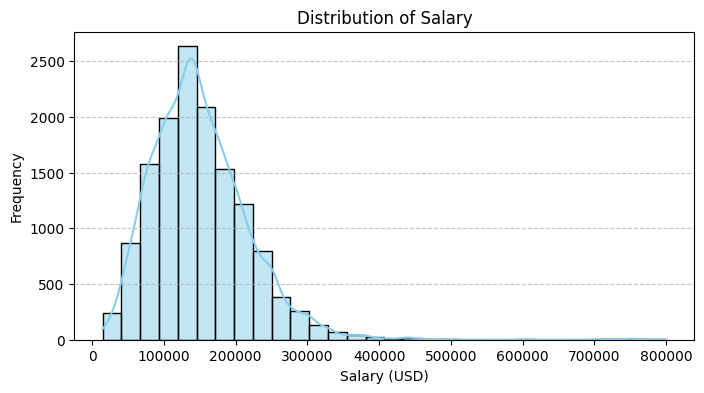

In [114]:
df = pd.read_csv("task2_USD.csv")

print("Basic Statistics for Salary:")
print(df['Salary'].describe())
print()

plt.figure(figsize=(8, 4))
sns.histplot(df['Salary'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Salary')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

To check if the salary data follows a normal distribution, we can employ statistical methods such as the Shapiro-Wilk test.

In [115]:
stat, p = shapiro(df['Salary'])
print("Shapiro-Wilk test for normality of Salary:")
print("Test Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Salary data follows a normal distribution.")
else:
    print("Salary data does not follow a normal distribution.")

Shapiro-Wilk test for normality of Salary:
Test Statistic: 0.9273092150688171
p-value: 0.0
Salary data does not follow a normal distribution.


c:\Users\tamir\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since the size of the data frame exceeds 5000 and the p-value is calculated numerically, visual inspection via a histogram or Q-Q plot is preferred for analysis.

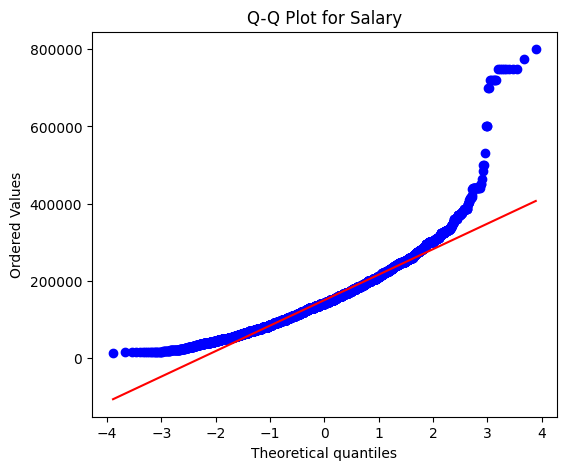

In [116]:
plt.figure(figsize=(6, 5))
probplot(df['Salary'], plot=plt)
plt.title('Q-Q Plot for Salary')
plt.show()

The Q-Q plot analysis indicates that while a significant portion of the salary data aligns with a normal distribution, there are notable deviations at the tails,outliers with behavior resembling an exponential distribution. 

To better visualize the density and distribution of salaries, we created violin plots and set the salaries into 50k intervals.

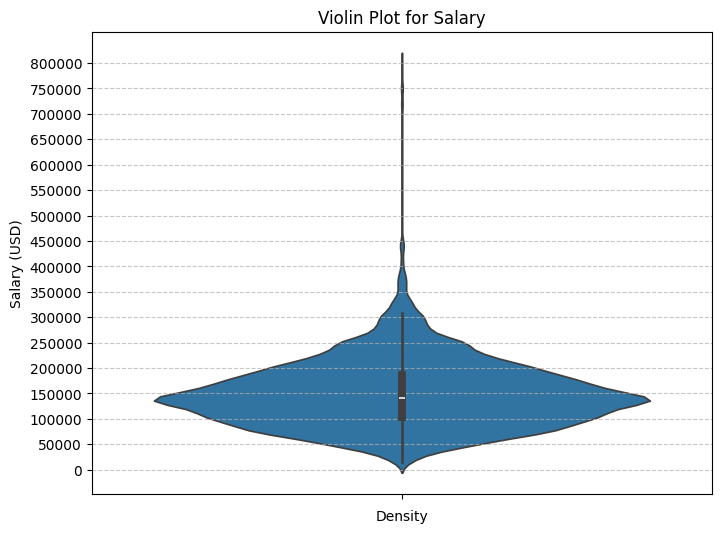

In [117]:
plt.figure(figsize=(8, 6))
sns.violinplot(y=df['Salary'])
plt.title('Violin Plot for Salary')
plt.xlabel('Density')
plt.ylabel('Salary (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#seting ticks at intervals of 50k for salary
salary_range = np.arange(0, df['Salary'].max() + 1, 50000)
plt.yticks(ticks=salary_range)

plt.show()

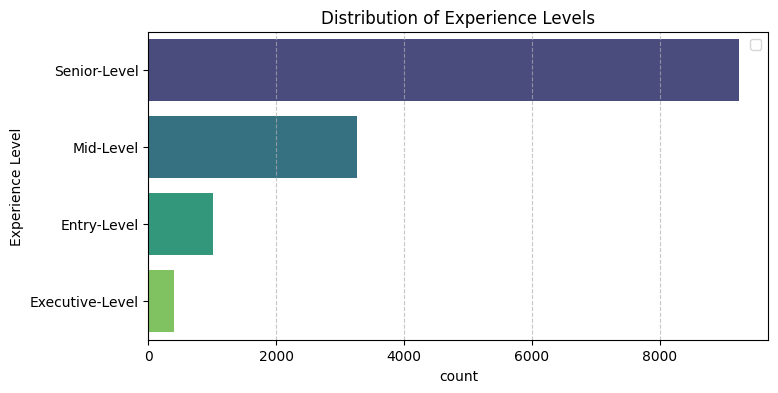

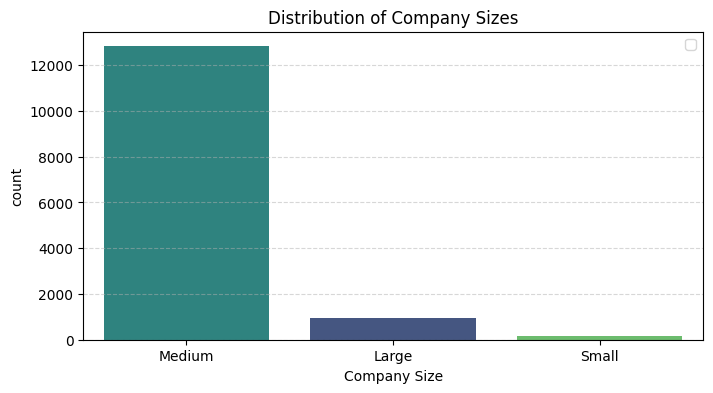

In [118]:
plt.figure(figsize=(8, 4))
sns.countplot(y='Experience_Level', data=df, order=df['Experience_Level'].value_counts().index, palette='viridis', hue='Experience_Level')
plt.title('Distribution of Experience Levels')
plt.ylabel('Experience Level')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend([])
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x='Company_Size', data=df, order=df['Company_Size'].value_counts().index,  palette='viridis', hue='Company_Size')
plt.title('Distribution of Company Sizes')
plt.xlabel('Company Size')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend([])
plt.show()



- The data from the plots indicates that there is a higher number of people at the senior level compared to other levels, and the company size tends to be medium.


#### Comparing Job Salaries with Other Data

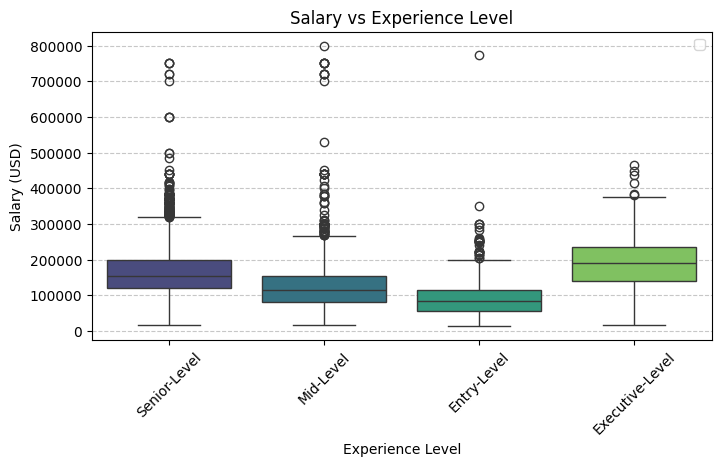

In [119]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Experience_Level', y='Salary', data=df, palette='viridis', hue='Experience_Level')
plt.title('Salary vs Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([])
plt.show()

- On average, executives are paid slightly more than those at the senior level. However, there are significantly higher outlier earnings among senior-level employees. Surprisingly, there are also outliers in the entry-level category with salaries equivalent to those of senior and mid-level positions.

To better identify outliers, we can examine the maximum outlier job titles, corresponding salaries, and years of work.

In [120]:
top_paid_entries = df.loc[df.groupby('Experience_Level')['Salary'].idxmax()]

print("Top Paid Entries in Each Experience Level:")
for index, row in top_paid_entries.iterrows():
    print(f"Experience Level: {row['Experience_Level']}")
    print(f"Job Title: {row['Job_Title']}")
    print(f"Salary (USD): {row['Salary']}")
    print(f"Year: {row['Work_Year']}")
    print()


Top Paid Entries in Each Experience Level:
Experience Level: Entry-Level
Job Title: Data Analyst
Salary (USD): 774000
Year: 2024

Experience Level: Executive-Level
Job Title: Data Engineer
Salary (USD): 465000
Year: 2023

Experience Level: Mid-Level
Job Title: AI Architect
Salary (USD): 800000
Year: 2024

Experience Level: Senior-Level
Job Title: Analytics Engineer
Salary (USD): 750000
Year: 2024



Also to gain a clearer understanding of the mean salaries at each level, we can plot the average salaries based on their experience levels.

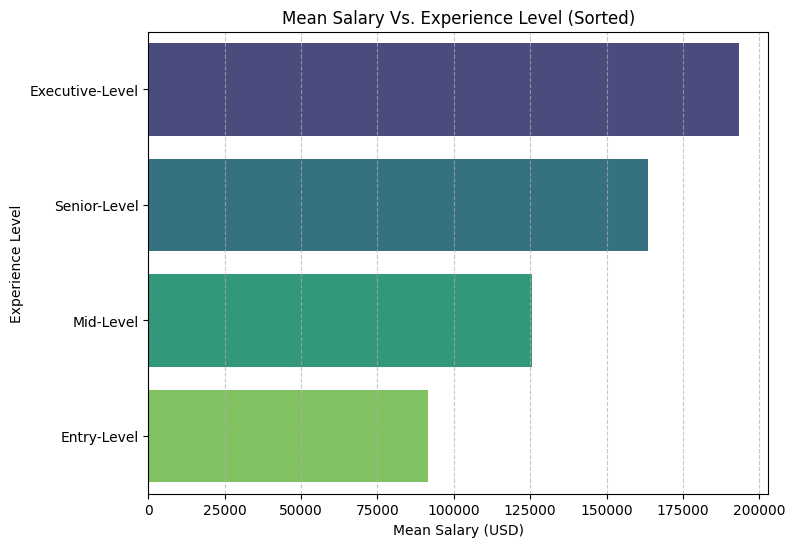

In [121]:
mean_salary_by_level = df.groupby('Experience_Level')['Salary'].mean().reset_index()
mean_salary_by_level_sorted = mean_salary_by_level.sort_values(by='Salary', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Salary', y='Experience_Level', data=mean_salary_by_level_sorted, hue='Experience_Level', palette='viridis', legend=False)
plt.title('Mean Salary Vs. Experience Level (Sorted)')
plt.xlabel('Mean Salary (USD)')
plt.ylabel('Experience Level')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


It's commonly perceived that executive-level positions, such as CFO or COO, typically command higher average salaries within organizations. This is largely attributed to their top-tier leadership roles and strategic influence within the company.

We were interested in exploring how the average salaries vary over the years in the field of Data Science.

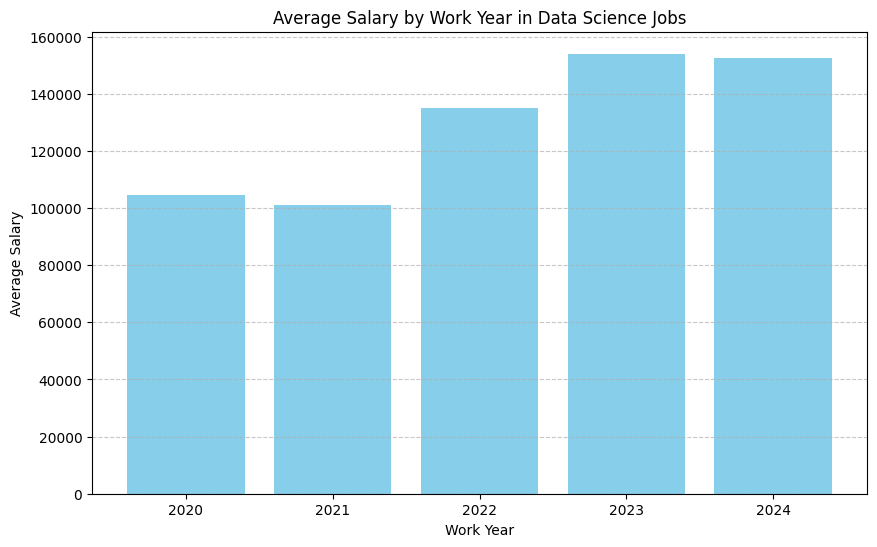

In [122]:
avg_salary_by_year = df.groupby('Work_Year')['Salary'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(avg_salary_by_year['Work_Year'], avg_salary_by_year['Salary'], color='skyblue')
plt.xlabel('Work Year')
plt.ylabel('Average Salary')
plt.title('Average Salary by Work Year in Data Science Jobs')
plt.xticks(avg_salary_by_year['Work_Year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

And also examining this further, we consider this for each job title that has a frequency of more than 200.

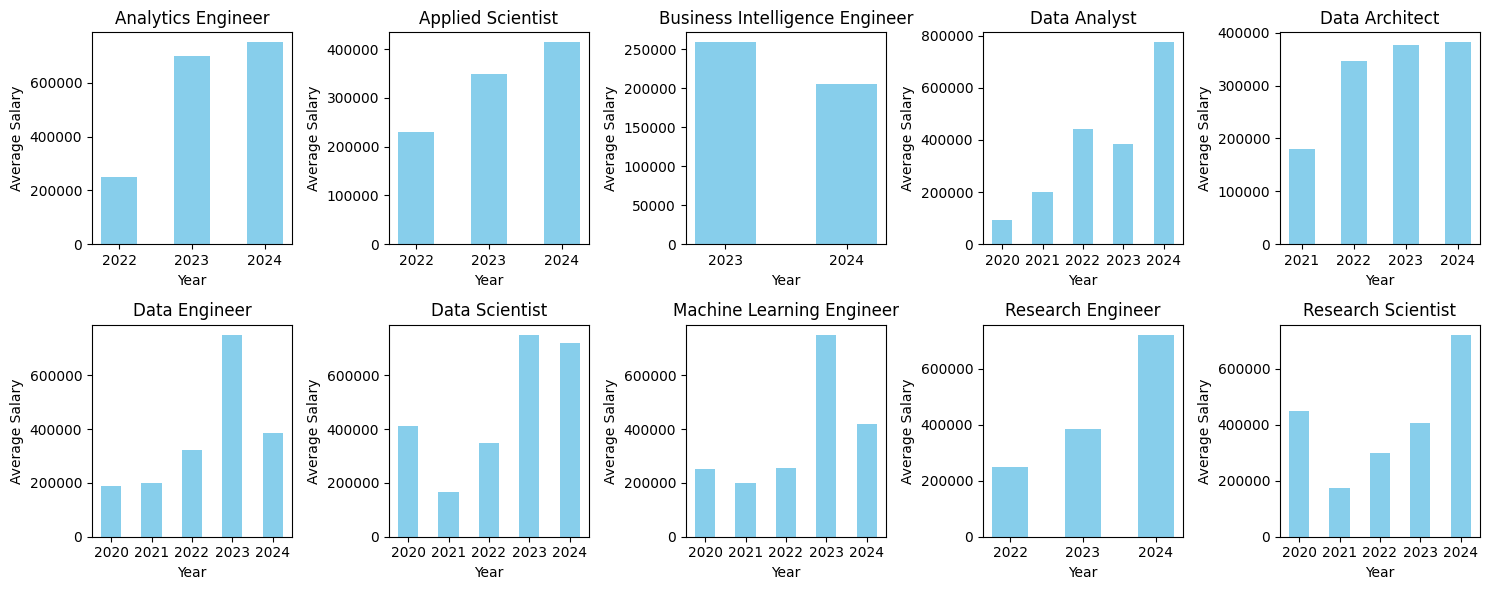

In [123]:
job_title_frequency = df['Job_Title'].value_counts()
filtered_jobs = job_title_frequency[job_title_frequency >= 200]

filtered_df = df[df['Job_Title'].isin(filtered_jobs.index)]
grouped_data = filtered_df.groupby('Job_Title')
plt.figure(figsize=(15, 6))
index = 1
for title, data in grouped_data:
    plt.subplot(2,5,index)
    plt.bar(data['Work_Year'], data['Salary'], width=0.5, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Average Salary')
    plt.title(title)
    plt.xticks(range(min(data['Work_Year']), max(data['Work_Year'])+1))
    plt.locator_params(axis='x', nbins=len(data['Work_Year']))
    plt.tight_layout()
    index += 1
plt.show()
    

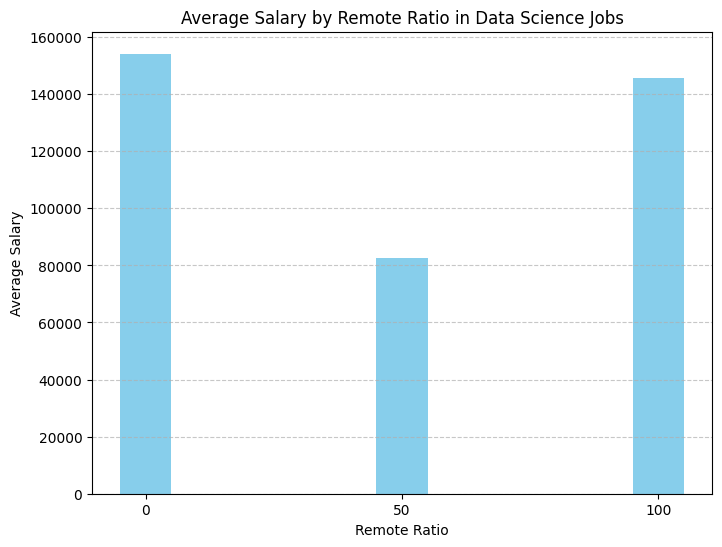

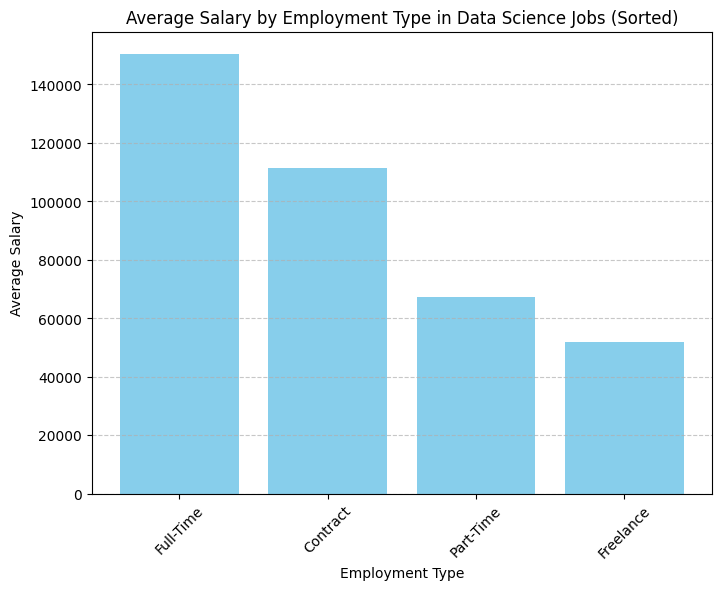

In [124]:
avg_salary_by_remote_ratio = df.groupby('Remote_Ratio')['Salary'].mean().reset_index()
avg_salary_by_employment_type = df.groupby('Employment_Type')['Salary'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(avg_salary_by_remote_ratio['Remote_Ratio'], avg_salary_by_remote_ratio['Salary'], color='skyblue', width=10)
plt.xlabel('Remote Ratio')
plt.ylabel('Average Salary')
plt.title('Average Salary by Remote Ratio in Data Science Jobs')
plt.xticks([0, 50, 100])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

avg_salary_by_employment_type_sorted = avg_salary_by_employment_type.sort_values(by='Salary', ascending=False)
plt.figure(figsize=(8, 6))
plt.bar(avg_salary_by_employment_type_sorted['Employment_Type'], avg_salary_by_employment_type_sorted['Salary'], color='skyblue')
plt.xlabel('Employment Type')
plt.ylabel('Average Salary')
plt.title('Average Salary by Employment Type in Data Science Jobs (Sorted)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


We observe a higher pay rate associated with freelance positions, and generally, roles with a significant remote work component tend to offer higher compensation.

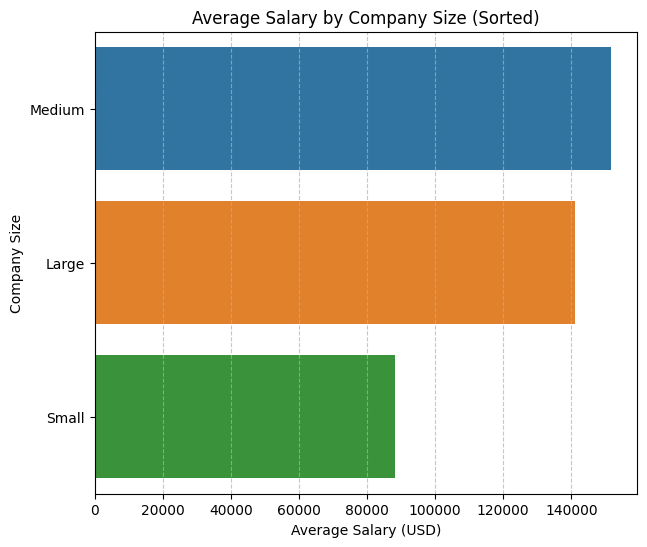

In [125]:
mean_salary_by_company_size = df.groupby('Company_Size')['Salary'].mean().reset_index()
mean_salary_by_company_size_sorted = mean_salary_by_company_size.sort_values(by='Salary', ascending=False)

plt.figure(figsize=(7, 6))
sns.barplot(x='Salary', y='Company_Size', hue='Company_Size', data=mean_salary_by_company_size_sorted)
plt.title('Average Salary by Company Size (Sorted)')
plt.xlabel('Average Salary (USD)')
plt.ylabel('Company Size')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Additionally, we will perform a comparative analysis of these factors, taking into account the level of experience.

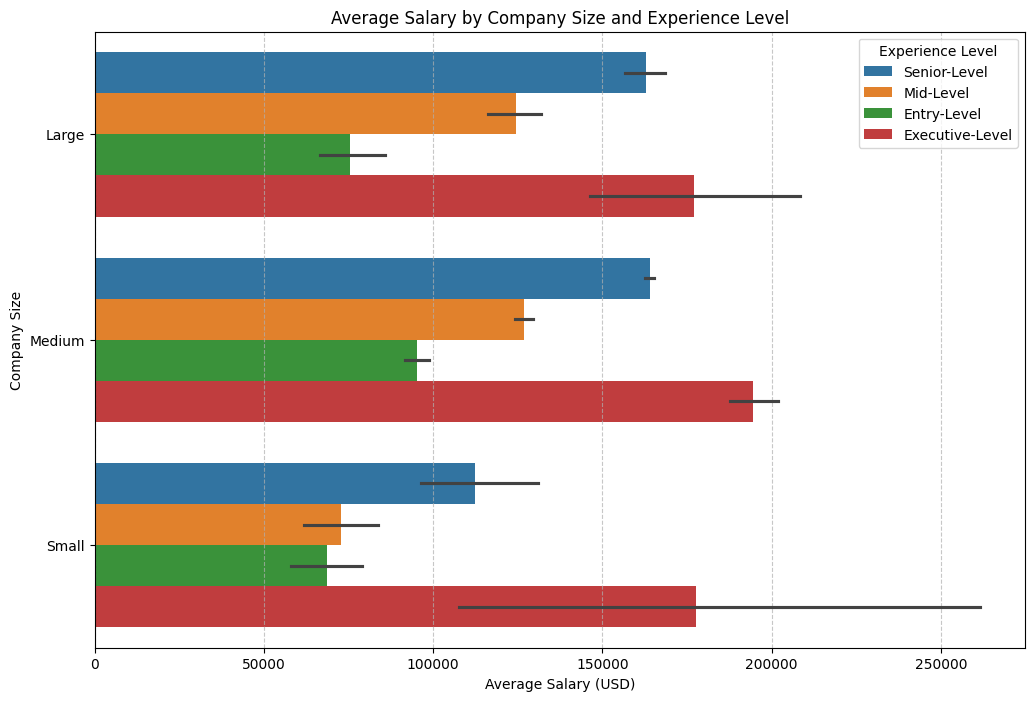

In [126]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Salary', y='Company_Size', hue='Experience_Level', data=df)
plt.title('Average Salary by Company Size and Experience Level')
plt.xlabel('Average Salary (USD)')
plt.ylabel('Company Size')
plt.legend(title='Experience Level', loc='best')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Plotting Pair Plot and Heat Map to Better Visualize the Correlation Between Variables

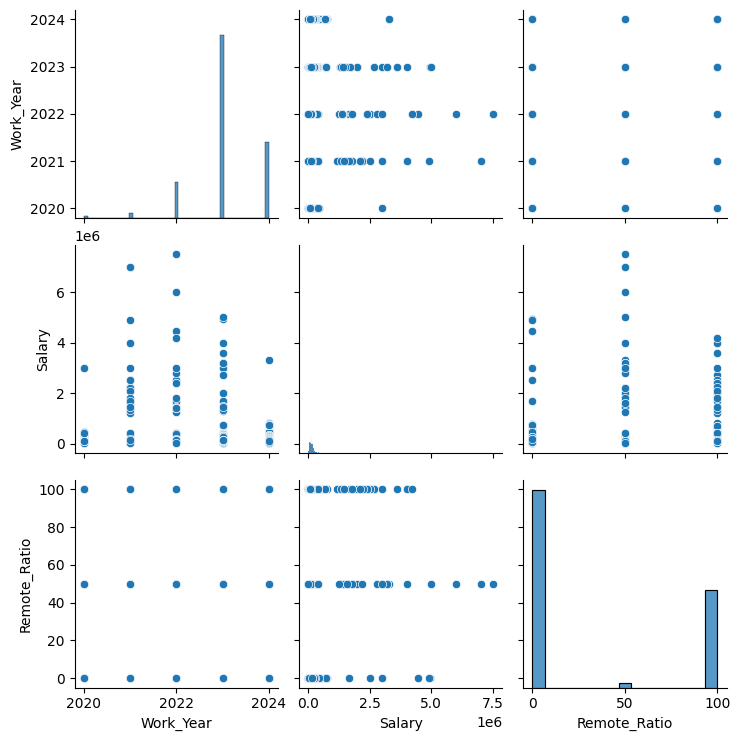

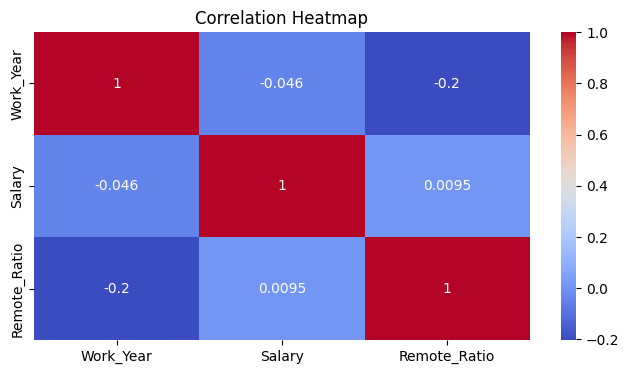

In [127]:
df = pd.read_csv('task2_cleaned.csv')
numeric_df = df.select_dtypes(include=['number'])

sns.pairplot(numeric_df)
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Based on the pair plot and correlation heatmap, it's evident that there is a positive correlation between work years and salary rates, indicating a gradual increase in salary over time.

Furthermore, in our detailed heatmap analysis, we also take into consideration non-numerical data.

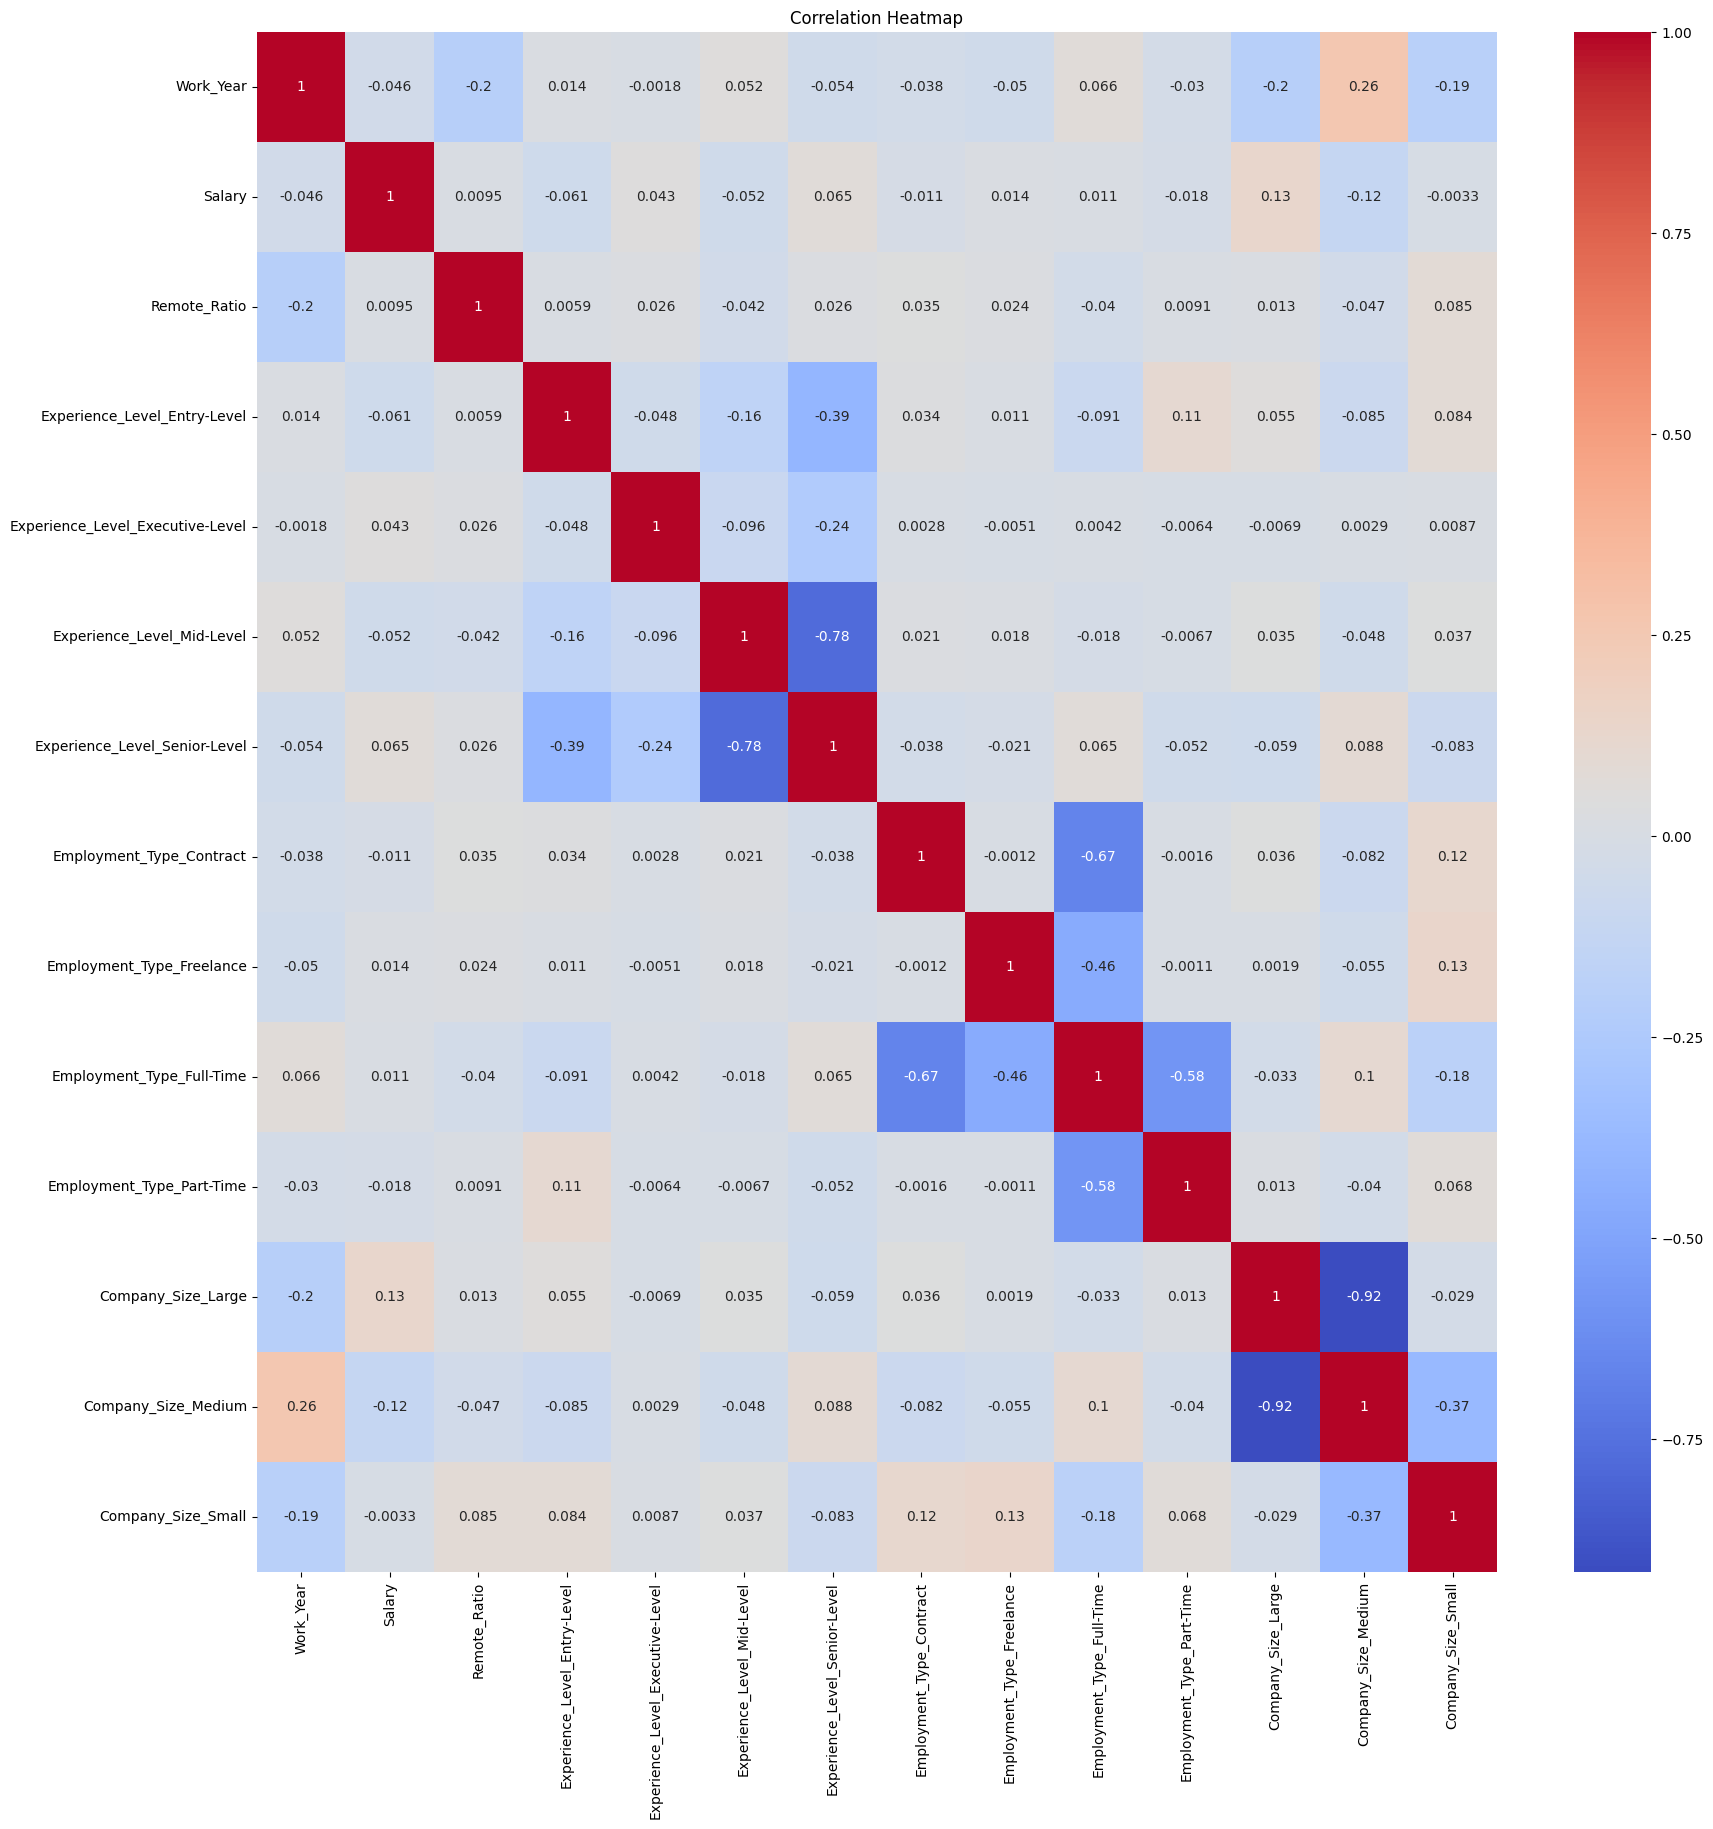

In [128]:
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('task2_cleaned.csv')
data = pd.get_dummies(data, columns=['Experience_Level', 'Employment_Type', 'Company_Size'], dtype=int)

scaler = MinMaxScaler()
numeric_columns = ['Work_Year', 'Salary', 'Remote_Ratio']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

numeric_data = data.select_dtypes(include=['number'])

plt.figure(figsize=(20, 20))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

For instance, we can conclude that there is a correlation of 0.13 between salary and company size for large companies. This suggests that individuals tend to receive higher compensation in larger companies. Moreover, when examining remote work ratios, smaller companies exhibit significantly higher rates compared to others. Additionally, over time, we observe a decrease in the number of small companies and a concurrent increase in the number of medium-sized companies.

#### Finding The Top 10 Highest-Paying  Jobs

In [129]:
top_10_job_titles = df['Job_Title'].value_counts().head(10)
top_10_paid_jobs = df.sort_values(by='Salary', ascending=False).head(10)

mean_salary_by_job_title = df.groupby('Job_Title')['Salary'].mean().round().reset_index()
mean_salary_by_job_title['Salary'] = mean_salary_by_job_title['Salary'].astype(int)

top_10_paid_jobs_mean = mean_salary_by_job_title.sort_values(by='Salary', ascending=False).head(10)

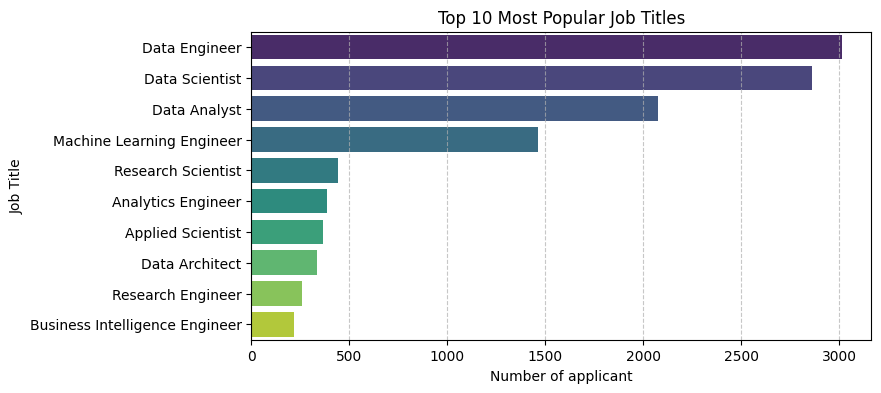

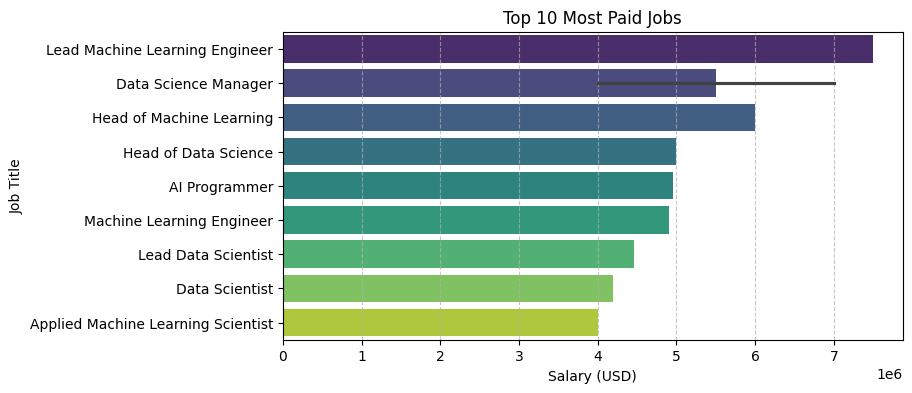

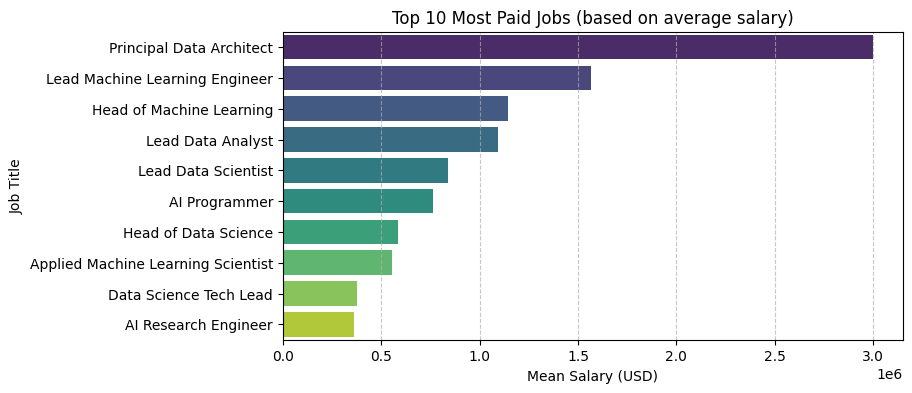

In [130]:
plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_job_titles.values, y=top_10_job_titles.index, hue=top_10_job_titles.index, palette='viridis', legend=False)
plt.title('Top 10 Most Popular Job Titles')
plt.xlabel('Number of applicant')
plt.ylabel('Job Title')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Salary', y='Job_Title', data=top_10_paid_jobs, hue='Job_Title', palette='viridis', legend=False)
plt.title('Top 10 Most Paid Jobs')
plt.xlabel('Salary (USD)')
plt.ylabel('Job Title')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Salary', y='Job_Title', data=top_10_paid_jobs_mean, hue='Job_Title', palette='viridis', legend=False)
plt.title('Top 10 Most Paid Jobs (based on average salary)')
plt.xlabel('Mean Salary (USD)')
plt.ylabel('Job Title')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


For the sake of interest, we can explore the dataset to identify the highest-paying freelance jobs.

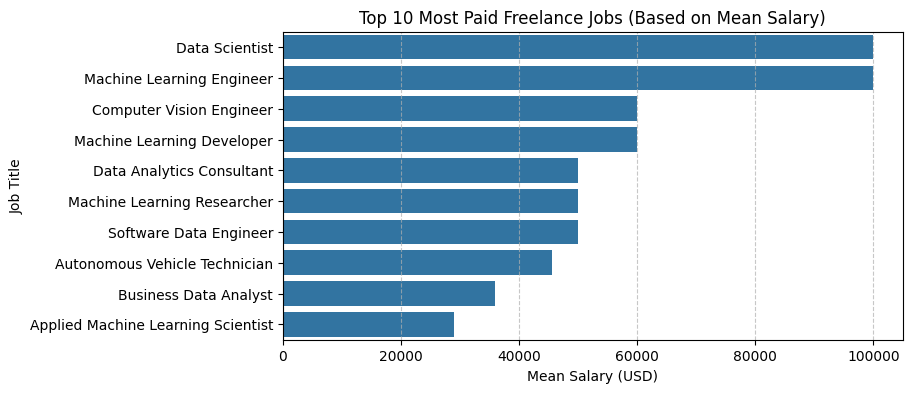

In [131]:
df = pd.read_csv("task2_USD.csv")
freelance_jobs = df[df['Employment_Type'] == 'Freelance']
mean_salary_by_job_title = freelance_jobs.groupby('Job_Title')['Salary'].mean().reset_index()
top_10_freelance_jobs = mean_salary_by_job_title.nlargest(10, 'Salary')
plt.figure(figsize=(8, 4))
sns.barplot(x='Salary', y='Job_Title', data=top_10_freelance_jobs)
plt.title('Top 10 Most Paid Freelance Jobs (Based on Mean Salary)')
plt.xlabel('Mean Salary (USD)')
plt.ylabel('Job Title')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
